# Generative process

## Definitions

We can generate participants' biomarker data according to EBM (Event-Based Model). 

$S \sim {\rm UniformPermutation}(\cdot)$

$S$ follows a distribution of uniform permutation. That means the ordering of biomarkers is random. 

$k_j \sim {\rm DiscreteUniform}(N)$

$k_j$ follows a discrete uniform distribution, which means a participant is equally likely to fall in a progression stage (e.g., from $0$ to $4$, where $0$ indicate this participant is healthy.)

<!-- $$X_{S(n)j} | S, k_j  \sim I(z_j == 1) \left[ I(S(n) \leq k_j ) p(X_{S(n)j} \mid \theta_{S(n)} ) +I(S(n) \gt k_j) p(X_{S(n)j} \mid \phi_{S(n)}) \right] +  \left(1-I(z_j==1) \right) p(X_{S(n)j} \mid \phi_{S(n)})$$ -->

<!-- \begin{align*}
X_{S(n)j} \mid S, k_j &\sim I(z_j == 1) \bigg[ I(S(n) \leq k_j) \, p(X_{S(n)j} \mid \theta_{S(n)}) + I(S(n) > k_j) \, p(X_{S(n)j} \mid \phi_{S(n)}) \bigg] \\
&\quad + \left(1 - I(z_j == 1) \right) p(X_{S(n)j} \mid \phi_{S(n)})
\end{align*} -->

\begin{align*}
X_{nj} \mid S, k_j &\sim I(z_j == 1) \bigg[ I(S(n) \leq k_j) \, p(X_{nj} \mid \theta_{n}) + I(S(n) > k_j) \, p(X_{nj} \mid \phi_{n}) \bigg] \\
&\quad + \left(1 - I(z_j == 1) \right) p(X_{nj} \mid \phi_{n})
\end{align*}


Note that $\sim$ in statistics indicates that this variable follows a certain distribution. Here, it means that the biomarker values is drawn from that distribution. 

## Explanation

$z_j$: $1$ if the participant is diseased; otherwise $0$.

$I(True) = 1$, $I(False) = 0$

$S$ denotes the ordering of a sequence of biomarkers. 

$N$: number of observed biomarkers.

$n$: a specific biomarker; e.g., biomarker $b$.

$J$: number of participants. 

$j$ denotes a participant. 

$X$ is observed values of biomarkers; it is a matrix of dimension of $N \times J$ or $J \times N$.

$S(n)$ means the disease stage that a specific biomarker $n$ indicates. 

$k_j$: disease stage that a participant is at. 

$X_{nj}$ means the observed value of the biomarker $n$ in participant $j$. 

$\theta_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has been affected by the disease. Let's assume this distribution is a Gaussian distribution.

$\phi_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has NOT been affected by the disease. 

<!-- ## Parameters

$z_j$: $1$ if the participant is diseased; otherwise $0$.

$I(True) = 1$, $I(False) = 0$

$S$ denotes the ordering of a sequence of biomarkers. 

$N$: number of observed biomarkers.

$n$: a specific biomarker; e.g., biomarker $b$.

$J$: number of participants. 

$j$ denotes a participant. 

$X$ is observed values of biomarkers; it is a matrix of dimension of $N \times J$ or $J \times N$.

$k$: a scalar whose value is the participant's stage of the disease

$K$: number of disease stages

$S(n)$ means the disease stage that a specific biomarker $n$ indicates. 

$k_j$: disease stage that a participant is at. 

$X_{nj}$ means the observed value of the biomarker $n$ in participant $j$. 

$\theta_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has been affected by the disease. Let's assume this distribution is a Gaussian distribution.

$\phi_n$ is the parameters for the probability density function (PDF) of observed value of biomarker $n$ when this biomarker has NOT been affected by the disease.  -->

## Simulation

**We are going to generate biomarker values for each participant by randomly drawing from distributions defined by $\theta$ or $\phi$. We will base our generation on Chen's paper (Figure 1).**

![](./img/chen_fig1.png)

In [115]:
import numpy as np
import scipy.stats as stats
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
n_participants = 100

In the following, let's first get the real theta and phi for each of the ten biomarkers, according to Chen's data. Remember that theta is abnormal and phi is normal:

In [117]:
all_ten_biomarker_names = np.array([
    'MMSE', 'ADAS', 'AB', 'P-Tau', 'HIP-FCI', 
    'HIP-GMI', 'AVLT-Sum', 'PCC-FCI', 'FUS-GMI', 'FUS-FCI'])
# in the order above
# cyan, normal
phi_means = [28, -6, 250, -25, 5, 0.4, 40, 12, 0.6, -10]
# black, abnormal
theta_means = [22, -20, 150, -50, -5, 0.3, 20, 5, 0.5, -20]
# cyan, normal
phi_std_times_three = [2, 4, 150, 50, 5, 0.7, 45, 12, 0.2, 10]
phi_stds = [std_dev/3 for std_dev in phi_std_times_three]
# black, abnormal
theta_std_times_three = [8, 12, 50, 100, 20, 1, 20, 10, 0.2, 18]
theta_stds = [std_dev/3 for std_dev in theta_std_times_three]

In [118]:
# np.where(all_ten_biomarker_names=="HIP-GMI")[0][0]

# theta_means = [1, 3, 5, 6, 8, 0, 4, 2, 7, 9]
# theta_stds = [0.3, 0.5, 0.2, 1.3, 3.3, 2.2, 0.8, 0.9, 0.7, 0.6]
# phi_means = [32, 31, 34, 36, 38, 39, 30, 33, 35, 37]
# phi_stds = [6.3, 7.4, 9.4, 4.9, 2.5, 5.9, 6.4, 7.7, 8.0, 3.0]

# to get the real_theta_phi means and stds
# dict_list = []
# for biomarker in all_ten_biomarker_names[0:5]:
#     i = np.where(all_ten_biomarker_names == biomarker)[0][0]
#     dic = {"biomarker": biomarker}
#     dic['theta_mean'] = theta_means[i]
#     dic['theta_std'] = theta_stds[i]
#     dic['phi_mean'] = phi_means[i]
#     dic['phi_std'] = phi_stds[i]
#     dict_list.append(dic)
# real_theta_phi = pd.DataFrame(dict_list)
# real_theta_phi

In [119]:
# S_ordering = np.array([
#     'HIP-FCI', 'PCC-FCI', 'AB', 'P-Tau', 'MMSE', 'ADAS', 
#     'HIP-GMI', 'AVLT-Sum', 'FUS-GMI', 'FUS-FCI'
#     ])
biomarkers_used_in_chen_data = np.array([
    'HIP-FCI', 'HIP-GMI', 'FUS-FCI', 'PCC-FCI', 'FUS-GMI'
])
S_ordering_in_chen_data = np.array([
    'HIP-FCI', 'PCC-FCI', 'HIP-GMI', 'FUS-GMI', 'FUS-FCI'
])
# chen ordering: [1, 3, 5, 2, 4]

In [120]:
## We only use five biomarkers for simplicity reasons
biomarkers = biomarkers_used_in_chen_data
S_ordering = S_ordering_in_chen_data
n_biomarkers = len(biomarkers)

In [121]:
# to get the real_theta_phi means and stds
dict_list = []
for biomarker in biomarkers:
    i = np.where(all_ten_biomarker_names == biomarker)[0][0]
    dic = {"biomarker": biomarker}
    dic['theta_mean'] = theta_means[i]
    dic['theta_std'] = theta_stds[i]
    dic['phi_mean'] = phi_means[i]
    dic['phi_std'] = phi_stds[i]
    dict_list.append(dic)
real_theta_phi = pd.DataFrame(dict_list)
real_theta_phi

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,HIP-FCI,-5.0,6.666667,5.0,1.666667
1,HIP-GMI,0.3,0.333333,0.4,0.233333
2,FUS-FCI,-20.0,6.000000,-10.0,3.333333
3,PCC-FCI,5.0,3.333333,12.0,4.000000
4,FUS-GMI,0.5,0.066667,0.6,0.066667


In [122]:
real_theta_phi.to_csv('data/means_stds.csv', index=False)

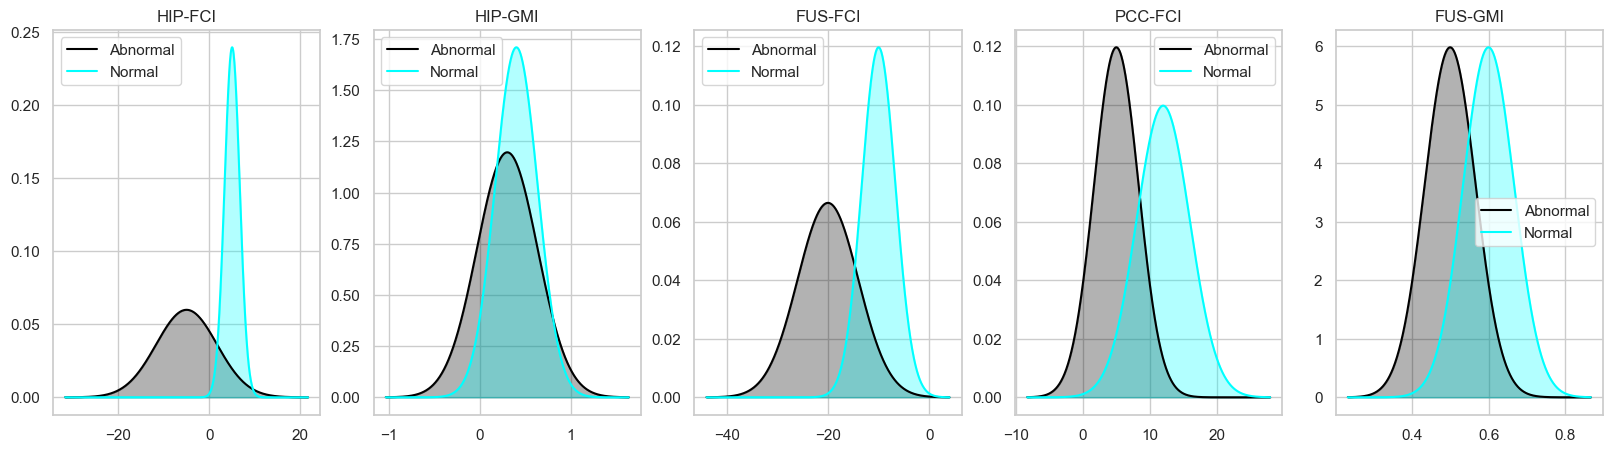

In [123]:
def plot_distribution_pair(ax, mu1, sigma1, mu2, sigma2, title):
    """mu1, sigma1: theta
    mu2, sigma2: phi
    """
    xmin = min(mu1 - 4*sigma1, mu2-4*sigma2)
    xmax = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    x = np.linspace(xmin, xmax, 1000)
    y1 = stats.norm.pdf(x, loc = mu1, scale = sigma1)
    y2 = stats.norm.pdf(x, loc = mu2, scale = sigma2)
    ax.plot(x, y1, label = "Abnormal", color = "black")
    ax.plot(x, y2, label = "Normal", color = "cyan")
    ax.fill_between(x, y1, alpha = 0.3, color = "black")
    ax.fill_between(x, y2, alpha = 0.3, color = "cyan")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, n_biomarkers, figsize=(20, 5))
for i, biomarker in enumerate(biomarkers):
    ax = axes.flatten()[i] 
    mu1, sigma1, mu2, sigma2 = real_theta_phi[
        real_theta_phi.biomarker == biomarker].reset_index().iloc[0, :][2:].values
    plot_distribution_pair(
        ax, mu1, sigma1, mu2, sigma2, title = biomarker)

In [124]:
for n, biomarker in enumerate(biomarkers):
    print(n, biomarker)

0 HIP-FCI
1 HIP-GMI
2 FUS-FCI
3 PCC-FCI
4 FUS-GMI


In [125]:
def simulate_ebm(
        biomarkers, S_ordering, n_participants, real_theta_phi):
    """
    Simulate an Event-Based Model (EBM) for disease progression.
    
    Args:
    biomarkers: Biomarker names
    S_ordering: Biomarker names ordered according to the order 
        in which each of them get affected 
    by the disease
    n_participants (int): Number of participants.
    real_theta_phi: pandas dataframes of theta and phi values for all biomarkers
    
    Returns:
    tuple: A tuple containing:
        - kjs (numpy.ndarray): The disease stages for participant.
        - X (numpy.ndarray): The biomarker matrix with participant data.
          - Each cell in X is tuple containing participantId, biomarker name, biomarker value, 
            disease stage of this participant, disease stage current biomarker indicates
            and healthy status
    """
    # N (int): Number of biomarkers.
    n_biomarkers = len(biomarkers)
    n_stages = n_biomarkers + 1
    
    # Generate a random stage for each participant
    # The stage should be between 0 and N, inclusive
    # stage 0 indicate the participant is healthy (normal)
    kjs = np.random.randint(0, n_stages, size=n_participants)
    
    # Initiate biomarker measurement matrix (J participants x N biomarkers), 
    # with entries as None
    X = np.full((n_participants, n_biomarkers), None, dtype=object)
    
    # biomarker : normal distribution
    theta_dist = {biomarker: stats.norm(
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['theta_mean'][0],
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['theta_std'][0]
        ) for biomarker in biomarkers}
    phi_dist = {biomarker: stats.norm(
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['phi_mean'][0],
        real_theta_phi[real_theta_phi.biomarker == biomarker].reset_index()['phi_std'][0]
        ) for biomarker in biomarkers}

    # Iterate through participants
    for j in range(n_participants):
        # Iterate through biomarkers
        for n, biomarker in enumerate(biomarkers):
            # Disease stage of the current participant
            k_j = kjs[j]
            # Disease stage indicated by the current biomarker
            # Note that biomarkers always indicate that the participant is diseased
            # Thus, S_n >= 1
            S_n = np.where(S_ordering == biomarker)[0][0] + 1
            
            # Assign biomarker values based on the participant's disease stage 
            # affected, or not_affected, is regarding the biomarker, not the participant
            if k_j >= 1:
                if k_j >= S_n:
                    X[j, n] = (j, biomarker, theta_dist[biomarker].rvs(), k_j, S_n, 'affected') 
                else:
                    X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')  
            # if the participant is healthy
            else:
                X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(), k_j, S_n, 'not_affected')        
    return kjs, X

In [126]:
kjs, X = simulate_ebm(biomarkers, S_ordering, n_participants, real_theta_phi)

In [127]:
kjs

array([2, 3, 2, 2, 3, 3, 5, 3, 4, 3, 0, 4, 3, 1, 5, 0, 0, 4, 2, 0, 3, 1,
       1, 3, 5, 1, 3, 2, 0, 4, 1, 1, 3, 5, 1, 1, 5, 3, 2, 4, 0, 4, 3, 0,
       0, 1, 5, 3, 4, 0, 2, 4, 1, 2, 4, 4, 0, 4, 1, 2, 1, 5, 4, 4, 4, 2,
       5, 5, 1, 3, 1, 5, 5, 3, 1, 0, 0, 3, 3, 1, 1, 4, 1, 0, 2, 1, 0, 1,
       5, 1, 4, 2, 2, 3, 1, 1, 3, 3, 5, 5])

In [128]:
n_sick = len(kjs[np.nonzero(kjs)])
n_sick

86

In [129]:
import plotly.express as px
import altair as alt
df = pd.DataFrame({'Values': kjs})

# Create a histogram using Altair
hist = alt.Chart(df).mark_bar().encode(
    alt.X('Values:O', bin  = False, title = "Disease Stage"),  # Bin the values
    alt.Y('count()', title = "Frequency")
).properties(
    title='Distribution of Disease Stages'
)

# Display the histogram
hist

alt.Chart(...)

In [130]:
# # Create a bar chart using Seaborn
# sns.set(style="whitegrid")
# plt.figure(figsize=(8, 6))
# ax = sns.countplot(x='Values', data=df, palette='viridis')

# # Add title and labels
# ax.set_title('Bar Chart of Value Frequencies')
# ax.set_xlabel('Value')
# ax.set_ylabel('Frequency')

# # Show the plot
# plt.show()

`X` is a `n_participants` $\times$ `n_biomarkers` matrix. Each row is a participant and each column is for a biomarker. Each cell is a tuple containing the following information: 

- participant id
- biomarker name
- biomarker measurement
- disease stage this participant is in
- disease stage this biomarker represents
- whether this biomarker is affected by this disease 

In [131]:
pd.DataFrame(X).head(3)

,0,1,2,3,4
0,"(0, HIP-FCI, -0.07888129475768757, 2, 1, affec...","(0, HIP-GMI, 0.3715909812478078, 2, 3, not_aff...","(0, FUS-FCI, -10.531440314652798, 2, 5, not_af...","(0, PCC-FCI, 9.35551931849504, 2, 2, affected)","(0, FUS-GMI, 0.6544424320609622, 2, 4, not_aff..."
1,"(1, HIP-FCI, -6.6010588591119355, 3, 1, affected)","(1, HIP-GMI, 0.4607972916097186, 3, 3, affected)","(1, FUS-FCI, -13.913080159070848, 3, 5, not_af...","(1, PCC-FCI, 0.36759438063001326, 3, 2, affected)","(1, FUS-GMI, 0.6757543768441079, 3, 4, not_aff..."
2,"(2, HIP-FCI, 4.6271928460915, 2, 1, affected)","(2, HIP-GMI, 0.46728040563856943, 2, 3, not_af...","(2, FUS-FCI, -16.568708505139153, 2, 5, not_af...","(2, PCC-FCI, 6.24781582599463, 2, 2, affected)","(2, FUS-GMI, 0.5625220516901407, 2, 4, not_aff..."


Please note that "not_affected" and "affected" refer to a specific biomarker, rather than this participant's health status. 

In [132]:
df = pd.DataFrame(X, columns=biomarkers)
df
# make this dataframe wide to long 
df_long = df.melt(var_name = "Biomarker", value_name="Value")
df_long
values_df = df_long['Value'].apply(pd.Series)
values_df.columns = ['participant', "biomarker", 'measurement', 'k_j', 'S_n', 'affected_or_not']
values_df

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,HIP-FCI,-0.078881,2,1,affected
1,1,HIP-FCI,-6.601059,3,1,affected
2,2,HIP-FCI,4.627193,2,1,affected
3,3,HIP-FCI,-9.682815,2,1,affected
4,4,HIP-FCI,-8.664428,3,1,affected
...,...,...,...,...,...,...
495,95,FUS-GMI,0.568443,1,4,not_affected
496,96,FUS-GMI,0.635572,3,4,not_affected
497,97,FUS-GMI,0.505707,3,4,not_affected
498,98,FUS-GMI,0.433660,5,4,affected


In [133]:
df = values_df
df.to_csv("data/participant_data.csv", index=False)
df.head()

,participant,biomarker,measurement,k_j,S_n,affected_or_not
0,0,HIP-FCI,-0.078881,2,1,affected
1,1,HIP-FCI,-6.601059,3,1,affected
2,2,HIP-FCI,4.627193,2,1,affected
3,3,HIP-FCI,-9.682815,2,1,affected
4,4,HIP-FCI,-8.664428,3,1,affected


## Visualizing simulated results

With the above data structure, we can visualize the following data:

- Distribution of all biomarker values by biomarker
- Distribution of all biomarker values when the participant is at a certain disease stage
- Comparing a certain biomarker data 
- A certain participant's data

### Distribution of all biomarker values by biomarker

In [134]:
alt.Chart(df).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data for all participants across all stages'
)

alt.Chart(...)

### Distribution of all biomarker values when the participant is at a certain disease stage

In [135]:
# biomarker data when the participant is at stage 6
df_kj_3 = df[df.k_j == 3]
df_kj_3

alt.Chart(df_kj_3).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 140,
    height = 200,
).properties(
    title='Biomarker data when the participant is at stage six'
)

alt.Chart(...)

### Comparing a certain biomarker data 

In [136]:
# select a biomarker
bio_data = df[df.biomarker=='HIP-FCI'].drop(['k_j', 'S_n', 'biomarker'], axis = 1)
# biomarker2 data, comparing from diseased and healthy groups
alt.Chart(bio_data).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['affected_or_not']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "affected_or_not:N",
    ),
    color=alt.Color(
        'affected_or_not:N'
    )
).properties(
    width= 240,
    height = 200,
).properties(
    title='HIP-FCI data, compring affected group and non-affected group'
)

alt.Chart(...)

### A certain participant's data

In [137]:
# participant 10
participant10_data = df[df.participant == 10]
alt.Chart(participant10_data).mark_bar().encode(
    x='biomarker',
    y='measurement',
    color=alt.Color(
        'affected_or_not:N'
    ),
    tooltip=['biomarker', 'affected_or_not', 'measurement']
).interactive().properties(
    title=f'Biomarker data for participant 10 (k_j = {participant10_data.k_j.to_list()[0]})'
)

alt.Chart(...)